# MRZ CRNN Training (v4: AttentionCRNN)

MRZ (Machine Readable Zone) 用の CRNN モデルを学習する。

## v4 変更点
- **AttentionCRNN に戻す**: EfficientCRNN (Depthwise Separable) から通常 Conv2d に変更
- **inplace=False**: CTC Loss との互換性を確保
- Depthwise Separable Conv は表現力が低く、精度が停滞していた

## アーキテクチャ
- **CNN Backbone**: 通常の Conv2d（高い表現力）
- **BiLSTM**: シーケンスモデリング
- **Self-Attention**: 文字間依存関係の学習
- **縦横比保護**: 拡張時に 0/O の識別特徴を維持
- **横解像度**: 320px

## 概要
- **入力**: 32x320 グレースケール画像
- **出力**: 44文字の MRZ テキスト
- **目標**: CER < 0.1%, Accuracy >= 99%

## 1. セットアップ

In [1]:
# GPU 確認
!nvidia-smi

Sat Dec 27 17:41:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# 必要なライブラリは Colab に事前インストール済み
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
import random
import time

# cuDNN最適化（低リスク高速化）
torch.backends.cudnn.benchmark = True  # 最適なアルゴリズム自動選択
torch.backends.cudnn.deterministic = False  # 再現性より速度優先

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"cuDNN benchmark: {torch.backends.cudnn.benchmark}")

PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla P100-PCIE-16GB
cuDNN benchmark: True


## 2. OCR-B フォント準備

MRZ は **OCR-B フォント** で印刷されている（国際標準）。
合成データも必ず OCR-B を使用する。

In [3]:
# OCR-B フォントをダウンロード（MRZ 標準フォント）
import urllib.request
import os

# jsDelivr CDN経由でダウンロード（安定したソース）
# 元ソース: https://github.com/jaycee723/ocr-b
OCRB_FONT_URL = "https://cdn.jsdelivr.net/gh/jaycee723/ocr-b/dist/OCR-B.otf"
OCRB_FONT_PATH = "/tmp/OCRB.otf"

if not os.path.exists(OCRB_FONT_PATH):
    print("OCR-B フォントをダウンロード中...")
    urllib.request.urlretrieve(OCRB_FONT_URL, OCRB_FONT_PATH)
    print(f"✅ ダウンロード完了: {OCRB_FONT_PATH}")
else:
    print(f"✅ OCR-B フォント準備済み: {OCRB_FONT_PATH}")

# フォント読み込みテスト
from PIL import ImageFont
try:
    test_font = ImageFont.truetype(OCRB_FONT_PATH, 24)
    print(f"✅ フォント読み込み成功")
except Exception as e:
    raise RuntimeError(f"OCR-B フォントの読み込みに失敗: {e}")

OCR-B フォントをダウンロード中...
✅ ダウンロード完了: /tmp/OCRB.otf
✅ フォント読み込み成功


In [4]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance
import string
import io

# MRZ で使用する文字セット
MRZ_CHARS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789<"

# 混同しやすい文字ペア（v3: 重点学習用）
CONFUSABLE_CHARS = "0ODQ1IL8B5S"


def generate_random_mrz_line(hard_mode: bool = False) -> str:
    """
    ランダムな MRZ 行（44文字）を生成
    
    Args:
        hard_mode: True の場合、混同しやすい文字を多く含む
    """
    if hard_mode:
        def pick_char(choices):
            if random.random() < 0.3 and any(c in CONFUSABLE_CHARS for c in choices):
                confusable = [c for c in choices if c in CONFUSABLE_CHARS]
                if confusable:
                    return random.choice(confusable)
            return random.choice(choices)
        pick_chars = lambda choices, k: "".join(pick_char(choices) for _ in range(k))
    else:
        pick_chars = lambda choices, k: "".join(random.choices(choices, k=k))
    
    if random.random() < 0.5:
        doc_type = random.choice(["P", "I", "A", "C"])
        country = pick_chars(string.ascii_uppercase, 3)
        name_len = random.randint(20, 35)
        name = pick_chars(string.ascii_uppercase + "<", name_len)
        line = f"{doc_type}<{country}{name}"
        line = line[:44].ljust(44, "<")
    else:
        passport_no = pick_chars(string.ascii_uppercase + string.digits, 9)
        check1 = random.choice(string.digits)
        nationality = pick_chars(string.ascii_uppercase, 3)
        dob = pick_chars(string.digits, 6)
        check2 = random.choice(string.digits)
        sex = random.choice(["M", "F", "<"])
        expiry = pick_chars(string.digits, 6)
        check3 = random.choice(string.digits)
        optional = pick_chars(string.ascii_uppercase + string.digits + "<", 14)
        check4 = random.choice(string.digits)
        line = f"{passport_no}{check1}{nationality}{dob}{check2}{sex}{expiry}{check3}{optional}{check4}"
        line = line[:44]
    
    return line


def apply_augmentation(img: Image.Image, intensity: float = 1.0) -> Image.Image:
    """
    データ拡張（v3: 縦横比保護 + Curriculum Learning対応）
    
    重要: OCR-B フォントでは 0 と O の違いが縦横比で表現される。
    拡張時に縦横比を歪めると、この識別特徴が失われる。
    → アフィン変換で等倍スケーリングを使用
    """
    # ブラー
    if random.random() < 0.3 * intensity:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.3, 1.0)))
    
    # 回転（縦横比を保持）
    if random.random() < 0.5 * intensity:
        angle = random.uniform(-2, 2) * intensity
        img = img.rotate(angle, fillcolor=255, resample=Image.BILINEAR)
    
    # アフィン変換（v3: 縦横比を保護）
    if random.random() < 0.2 * intensity:
        w, h = img.size
        
        # 等倍スケーリング: x と y を同じ倍率で変換
        # これにより 0(狭い) と O(広い) の違いが保持される
        scale = 1 + random.uniform(-0.02, 0.02) * intensity
        
        # せん断（shear）は横方向のみ許容（文字幅に影響しにくい）
        shear_x = random.uniform(-0.01, 0.01) * intensity
        
        # 平行移動
        tx = random.uniform(-0.02, 0.02) * w * intensity
        ty = random.uniform(-0.02, 0.02) * h * intensity
        
        coeffs = [
            scale,      # x スケール
            shear_x,    # x せん断
            tx,         # x 平行移動
            0,          # y せん断 (0 で縦横比保護)
            scale,      # y スケール (x と同じ)
            ty,         # y 平行移動
        ]
        img = img.transform((w, h), Image.AFFINE, coeffs, fillcolor=255)
    
    # 明るさ
    if random.random() < 0.4 * intensity:
        factor = 1.0 + (random.uniform(-0.2, 0.2) * intensity)
        img = ImageEnhance.Brightness(img).enhance(factor)
    
    # コントラスト
    if random.random() < 0.4 * intensity:
        factor = 1.0 + (random.uniform(-0.2, 0.2) * intensity)
        img = ImageEnhance.Contrast(img).enhance(factor)
    
    # JPEG圧縮アーティファクト
    if random.random() < 0.2 * intensity:
        quality = int(95 - 25 * intensity)
        buffer = io.BytesIO()
        img.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        img = Image.open(buffer).convert('L')
    
    return img


def render_mrz_image(
    text: str,
    height: int = 32,
    font_size: int = 24,
    augment_intensity: float = 1.0
) -> np.ndarray:
    """MRZ テキストを OCR-B フォントで画像にレンダリング"""
    # OCR-B フォントのみ使用（MRZ標準、フォールバックなし）
    font = ImageFont.truetype(OCRB_FONT_PATH, font_size)
    
    dummy_img = Image.new("L", (1, 1))
    dummy_draw = ImageDraw.Draw(dummy_img)
    bbox = dummy_draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    padding = 4
    img_width = text_width + padding * 2
    img = Image.new("L", (img_width, height), color=255)
    draw = ImageDraw.Draw(img)
    
    y_offset = (height - text_height) // 2
    draw.text((padding, y_offset), text, font=font, fill=0)
    
    if augment_intensity > 0:
        img = apply_augmentation(img, intensity=augment_intensity)
    
    img_array = np.array(img)
    
    if augment_intensity > 0 and random.random() < 0.6 * augment_intensity:
        sigma = random.uniform(3, 10) * augment_intensity
        noise = np.random.normal(0, sigma, img_array.shape)
        img_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    
    return img_array


# テスト
print("v3: OCR-B + 縦横比保護 + Curriculum Learning + Hard Mode")
print("\n通常サンプル:")
print(f"  {generate_random_mrz_line(hard_mode=False)}")
print("\n混同文字重点サンプル:")
hard = generate_random_mrz_line(hard_mode=True)
print(f"  {hard}")
print(f"  混同文字数: {sum(1 for c in hard if c in CONFUSABLE_CHARS)}")

v3: OCR-B + 縦横比保護 + Curriculum Learning + Hard Mode

通常サンプル:
  C<HFWTTPZJZKQKAISKEKHQVOK<<<<<<<<<<<<<<<<<<<

混同文字重点サンプル:
  I<IDMGQOSDKKFQQIPRRQZILBDE<<<<<<<<<<<<<<<<<<
  混同文字数: 15


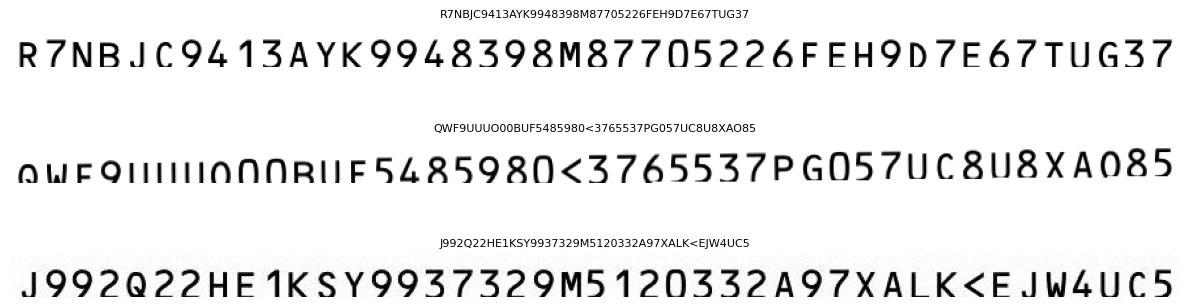

In [5]:
# サンプル画像を表示
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 4))
for i, ax in enumerate(axes):
    text = generate_random_mrz_line()
    img = render_mrz_image(text)
    ax.imshow(img, cmap="gray")
    ax.set_title(text, fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

## 3. Dataset & DataLoader

In [6]:
from torch.utils.data import Dataset, DataLoader

# 文字セット定義
CHARS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789<"
CHAR_TO_IDX = {c: i for i, c in enumerate(CHARS)}
IDX_TO_CHAR = {i: c for i, c in enumerate(CHARS)}
NUM_CLASSES = len(CHARS) + 1  # +1 for CTC blank

print(f"文字数: {len(CHARS)}")
print(f"クラス数 (blank含む): {NUM_CLASSES}")


def encode_text(text: str) -> list:
    """テキストを数値インデックスに変換"""
    return [CHAR_TO_IDX[c] for c in text if c in CHAR_TO_IDX]


def decode_output(indices: list) -> str:
    """
    CTC 出力をテキストにデコード
    連続する同一インデックスと blank を除去
    """
    result = []
    prev_idx = -1
    for idx in indices:
        if idx == len(CHARS):  # blank
            prev_idx = idx
            continue
        if idx != prev_idx and idx < len(CHARS):
            result.append(IDX_TO_CHAR[idx])
        prev_idx = idx
    return "".join(result)


class SyntheticMRZDataset(Dataset):
    """
    合成 MRZ データセット (v3: Curriculum Learning + Hard Mode対応)
    
    オンラインでランダムに MRZ 画像を生成する。
    - augment_intensity: 拡張強度（Curriculum Learningで段階的に上げる）
    - hard_ratio: 混同文字重点サンプルの割合
    """
    
    def __init__(
        self, 
        num_samples: int, 
        max_width: int = 280,
        augment_intensity: float = 1.0,
        hard_ratio: float = 0.3
    ):
        self.num_samples = num_samples
        self.max_width = max_width
        self.augment_intensity = augment_intensity
        self.hard_ratio = hard_ratio
    
    def set_augment_intensity(self, intensity: float):
        """Curriculum Learning 用: 拡張強度を動的に変更"""
        self.augment_intensity = intensity
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # hard_ratio の確率で混同文字重点サンプルを生成
        hard_mode = random.random() < self.hard_ratio
        text = generate_random_mrz_line(hard_mode=hard_mode)
        image = render_mrz_image(text, augment_intensity=self.augment_intensity)
        
        # 正規化 (0-1)
        image = image.astype(np.float32) / 255.0
        
        # パディング（幅を max_width に統一）
        h, w = image.shape
        if w < self.max_width:
            pad_w = self.max_width - w
            image = np.pad(image, ((0, 0), (0, pad_w)), constant_values=1.0)
        elif w > self.max_width:
            image = image[:, :self.max_width]
        
        # テンソルに変換 (1, H, W)
        image_tensor = torch.from_numpy(image).unsqueeze(0)
        label = encode_text(text)
        
        return {
            "image": image_tensor,
            "label": torch.tensor(label, dtype=torch.long),
            "label_length": len(label),
            "text": text
        }


def collate_fn(batch):
    """バッチをまとめる（CTC Loss 用）"""
    images = torch.stack([item["image"] for item in batch])
    labels = torch.cat([item["label"] for item in batch])
    label_lengths = torch.tensor([item["label_length"] for item in batch])
    texts = [item["text"] for item in batch]
    return {
        "images": images,
        "labels": labels,
        "label_lengths": label_lengths,
        "texts": texts
    }


print("Dataset: v3 (Curriculum Learning + Hard Mode対応)")

文字数: 37
クラス数 (blank含む): 38
Dataset: v3 (Curriculum Learning + Hard Mode対応)


## 4. CRNN モデル

In [7]:
class AttentionCRNN(nn.Module):
    """
    Attention-enhanced CRNN for MRZ OCR (v4)
    
    アーキテクチャ:
    - CNN Backbone: 通常の Conv2d（高い表現力）
    - BiLSTM: シーケンスモデリング
    - Self-Attention: 文字間依存関係の学習
    - Linear: 文字分類（37クラス + CTC blank）
    
    v4 変更点:
    - EfficientCRNN (Depthwise Separable) から通常 Conv2d に戻す
    - inplace=False で CTC Loss との互換性を確保
    
    入力: (B, 1, 32, W) - グレースケール画像
    出力: (T, B, 38) - 各タイムステップの文字確率
    """
    
    def __init__(self, num_classes: int = 38, hidden_size: int = 128, dropout: float = 0.2):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        # CNN Backbone（通常の Conv2d で高い表現力を確保）
        self.cnn = nn.Sequential(
            # Block 1: 32 -> 16
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False),  # CTC 互換性のため inplace=False
            nn.MaxPool2d(2, 2),
            
            # Block 2: 16 -> 8
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(2, 2),
            
            # Block 3: 8 -> 4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=False),
            nn.MaxPool2d((2, 1)),  # 高さのみ縮小、幅は保持
            
            # Block 4: 4 -> 2
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=False),
            nn.MaxPool2d((2, 1)),
            
            # Block 5: 2 -> 1
            nn.Conv2d(256, 256, kernel_size=(2, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=False),
        )
        
        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=False,
            dropout=dropout
        )
        
        # Self-Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,
            num_heads=4,
            dropout=dropout,
            batch_first=False
        )
        
        # LayerNorm + Dropout
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout)
        
        # 出力層
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        # CNN 特徴抽出: (B, 1, 32, W) -> (B, 256, 1, W')
        features = self.cnn(x)
        
        # 形状変換: (B, C, 1, W') -> (W', B, C) = (T, B, C)
        b, c, h, w = features.shape
        features = features.squeeze(2)
        features = features.permute(2, 0, 1)  # (T, B, C)
        
        # BiLSTM
        lstm_out, _ = self.lstm(features)
        
        # Self-Attention + Residual
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        out = self.layer_norm(lstm_out + attn_out)
        out = self.dropout(out)
        
        # 出力
        output = self.fc(out)
        output = torch.log_softmax(output, dim=2)
        
        return output


def get_model_info(model):
    """モデル情報を取得"""
    total_params = sum(p.numel() for p in model.parameters())
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / 1024 / 1024
    return {"total_params": total_params, "size_mb": size_mb}


# AttentionCRNN (v4) を使用
model = AttentionCRNN(num_classes=NUM_CLASSES, dropout=0.2)
info = get_model_info(model)

print("=" * 50)
print("モデル: AttentionCRNN (v4)")
print("=" * 50)
print(f"パラメータ数: {info['total_params']:,}")
print(f"モデルサイズ: {info['size_mb']:.2f} MB")

# 推論テスト
x = torch.randn(1, 1, 32, 320)
output = model(x)
print(f"\n入力: {x.shape}")
print(f"出力: {output.shape}")
print(f"シーケンス長: {output.shape[0]}")

print(f"\n✅ AttentionCRNN (v4) を使用")

モデル: AttentionCRNN (v4)
パラメータ数: 1,584,614
モデルサイズ: 6.05 MB

入力: torch.Size([1, 1, 32, 320])
出力: torch.Size([80, 1, 38])
シーケンス長: 80

✅ AttentionCRNN (v4) を使用


## 5. 学習

In [8]:
import os
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

# ハイパーパラメータ (v4: AttentionCRNN)
BATCH_SIZE = 128
EPOCHS = 100
LR = 5e-4
WEIGHT_DECAY = 0.01
TRAIN_SAMPLES = 10000
VAL_SAMPLES = 2000
MAX_WIDTH = 320

# Curriculum Learning パラメータ
# Stage 3（フル拡張）を60%確保し、実際の推論条件での学習時間を十分に取る
CURRICULUM_STAGES = [
    # (開始epoch, augment_intensity, hard_ratio)
    (1, 0.3, 0.1),      # Stage 1: epoch 1-19  (20%) 基礎固め
    (20, 0.6, 0.2),     # Stage 2: epoch 20-39 (20%) 中程度
    (40, 1.0, 0.3),     # Stage 3: epoch 40+   (60%) フル拡張
]

# デバイス
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

NUM_WORKERS = 0
print(f"num_workers: {NUM_WORKERS} (オンライン生成のため)")

# データセット（初期は低強度）
initial_intensity, initial_hard_ratio = CURRICULUM_STAGES[0][1], CURRICULUM_STAGES[0][2]
train_dataset = SyntheticMRZDataset(
    TRAIN_SAMPLES, MAX_WIDTH,
    augment_intensity=initial_intensity,
    hard_ratio=initial_hard_ratio
)
val_dataset = SyntheticMRZDataset(VAL_SAMPLES, MAX_WIDTH, augment_intensity=1.0, hard_ratio=0.3)

# DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Train samples: {TRAIN_SAMPLES:,}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"MAX_WIDTH: {MAX_WIDTH}")

# モデル (v4: AttentionCRNN - 通常 Conv2d)
model = AttentionCRNN(num_classes=NUM_CLASSES, dropout=0.2).to(device)
info = get_model_info(model)
print(f"\nモデル: AttentionCRNN (v4)")
print(f"パラメータ数: {info['total_params']:,}")
print(f"モデルサイズ: {info['size_mb']:.2f} MB")

criterion = nn.CTCLoss(blank=NUM_CLASSES - 1, zero_infinity=True)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=LR * 5,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    anneal_strategy='cos'
)

print(f"\n[v4 AttentionCRNN]")
print(f"バッチサイズ: {BATCH_SIZE}")
print(f"エポック数: {EPOCHS}")
print(f"学習率: {LR}, max_lr: {LR * 5:.4f}")
print(f"ウォームアップ: 20%")
print(f"Curriculum Learning:")
print(f"  Stage 1 (epoch 1-19):  intensity=0.3, hard_ratio=0.1  (20%)")
print(f"  Stage 2 (epoch 20-39): intensity=0.6, hard_ratio=0.2  (20%)")
print(f"  Stage 3 (epoch 40+):   intensity=1.0, hard_ratio=0.3  (60%)")

Device: cuda
num_workers: 0 (オンライン生成のため)
Train samples: 10,000
Train batches: 79
Val batches: 16
MAX_WIDTH: 320

モデル: AttentionCRNN (v4)
パラメータ数: 1,584,614
モデルサイズ: 6.05 MB

[v4 AttentionCRNN]
バッチサイズ: 128
エポック数: 100
学習率: 0.0005, max_lr: 0.0025
ウォームアップ: 20%
Curriculum Learning:
  Stage 1 (epoch 1-19):  intensity=0.3, hard_ratio=0.1  (20%)
  Stage 2 (epoch 20-39): intensity=0.6, hard_ratio=0.2  (20%)
  Stage 3 (epoch 40+):   intensity=1.0, hard_ratio=0.3  (60%)


In [9]:
# PyTorch 2.x 対応の AMP API
from torch.amp import autocast, GradScaler
import warnings

def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, scaler):
    """
    1エポック分の学習（AMP対応で高速化）
    
    Mixed Precision Training:
    - forward passをFP16で実行（高速化 + メモリ削減）
    - backward passはFP32で実行（精度維持）
    - GradScalerでgradientのunderflow防止
    """
    model.train()
    total_loss = 0.0
    
    for batch in dataloader:
        images = batch["images"].to(device)
        labels = batch["labels"].to(device)
        label_lengths = batch["label_lengths"]
        
        optimizer.zero_grad()
        
        # Mixed Precision: forward pass をFP16で実行
        with autocast('cuda'):
            outputs = model(images)  # (T, B, C)
            T, B, C = outputs.shape
            input_lengths = torch.full((B,), T, dtype=torch.long)
            loss = criterion(outputs, labels, input_lengths, label_lengths)
        
        # Backward with gradient scaling
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        
        # scheduler.step() の警告を抑制
        # (GradScalerがinf/nan検出時にoptimizer.stepをスキップする場合の誤警告)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message=".*lr_scheduler.step.*")
            scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def validate(model, dataloader, device):
    """検証"""
    model.eval()
    total_chars = 0
    total_errors = 0
    correct = 0
    total = 0
    samples = []
    
    with torch.no_grad():
        for batch in dataloader:
            images = batch["images"].to(device)
            texts = batch["texts"]
            
            with autocast('cuda'):
                outputs = model(images)
            
            for i, text in enumerate(texts):
                probs = outputs[:, i, :]
                pred_indices = probs.argmax(dim=1).cpu().tolist()
                pred_text = decode_output(pred_indices)
                
                errors = sum(1 for a, b in zip(text, pred_text) if a != b)
                errors += abs(len(text) - len(pred_text))
                total_chars += len(text)
                total_errors += errors
                
                if text == pred_text:
                    correct += 1
                total += 1
                
                if len(samples) < 5:
                    samples.append({"gt": text, "pred": pred_text, "match": text == pred_text})
    
    cer = (total_errors / total_chars) * 100 if total_chars > 0 else 0
    accuracy = (correct / total) * 100 if total > 0 else 0
    
    return {"cer": cer, "accuracy": accuracy, "samples": samples}

In [10]:
# 学習ループ (v3: Curriculum Learning + AMP)
print("=" * 60)
print("学習開始 (v3: Curriculum Learning + Mixed Precision)")
print("=" * 60)

# GradScaler for AMP (PyTorch 2.x API)
scaler = GradScaler('cuda')

best_cer = float("inf")
best_epoch = 0
VAL_FREQUENCY = 5  # 5エポックごとに検証

history = {"train_loss": [], "val_cer": [], "val_acc": [], "lr": []}
current_stage = 0  # Curriculum Learning のステージ追跡

start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
    
    # === Curriculum Learning: ステージ更新 ===
    # 現在のエポックに応じて拡張強度と混同文字比率を調整
    for stage_idx, (stage_epoch, intensity, hard_ratio) in enumerate(CURRICULUM_STAGES):
        if epoch >= stage_epoch:
            if stage_idx > current_stage:
                current_stage = stage_idx
                train_dataset.augment_intensity = intensity
                train_dataset.hard_ratio = hard_ratio
                print(f"\n📈 Curriculum Stage {stage_idx + 1}: intensity={intensity}, hard_ratio={hard_ratio}")
    
    current_lr = optimizer.param_groups[0]['lr']
    history["lr"].append(current_lr)
    
    # 学習
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device, scaler)
    history["train_loss"].append(train_loss)
    
    epoch_time = time.time() - epoch_start
    
    # 検証（5エポックごと or 最初の10エポック or 最終エポック or ステージ変更直後）
    is_stage_change = any(epoch == s[0] for s in CURRICULUM_STAGES)
    if epoch <= 10 or epoch % VAL_FREQUENCY == 0 or epoch == EPOCHS or is_stage_change:
        val_result = validate(model, val_loader, device)
        history["val_cer"].append(val_result["cer"])
        history["val_acc"].append(val_result["accuracy"])
        
        stage_info = f"[S{current_stage + 1}]" if current_stage > 0 else ""
        print(f"Epoch {epoch:3d}/{EPOCHS} {stage_info} | "
              f"Loss: {train_loss:.4f} | "
              f"CER: {val_result['cer']:.2f}% | "
              f"Acc: {val_result['accuracy']:.1f}% | "
              f"LR: {current_lr:.2e} | "
              f"Time: {epoch_time:.1f}s")
        
        # ベストモデル保存
        if val_result["cer"] < best_cer:
            best_cer = val_result["cer"]
            best_epoch = epoch
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "cer": best_cer,
                "accuracy": val_result["accuracy"]
            }, "best_model.pth")
            print(f"  -> Best model saved (CER: {best_cer:.2f}%)")
        
        # サンプル表示（30エポックごと）
        if epoch % 30 == 0:
            print("\n  サンプル予測:")
            for s in val_result["samples"][:3]:
                mark = "✓" if s["match"] else "✗"
                print(f"    GT:   {s['gt']}")
                print(f"    Pred: {s['pred']} [{mark}]")
            print()

total_time = time.time() - start_time
print("\n" + "=" * 60)
print("学習完了 (v3)")
print("=" * 60)
print(f"総学習時間: {total_time:.1f}秒 ({total_time/60:.1f}分)")
print(f"ベスト CER: {best_cer:.2f}% (Epoch {best_epoch})")
print(f"目標: CER < 0.1%, Accuracy >= 99%")

学習開始 (v3: Curriculum Learning + Mixed Precision)
Epoch   1/100  | Loss: 3.5034 | CER: 98.44% | Acc: 0.0% | LR: 1.00e-04 | Time: 44.9s
  -> Best model saved (CER: 98.44%)
Epoch   2/100  | Loss: 3.1714 | CER: 98.31% | Acc: 0.0% | LR: 1.15e-04 | Time: 32.8s
  -> Best model saved (CER: 98.31%)
Epoch   3/100  | Loss: 3.0178 | CER: 98.24% | Acc: 0.0% | LR: 1.59e-04 | Time: 32.7s
  -> Best model saved (CER: 98.24%)
Epoch   4/100  | Loss: 2.9243 | CER: 97.79% | Acc: 0.0% | LR: 2.31e-04 | Time: 32.6s
  -> Best model saved (CER: 97.79%)
Epoch   5/100  | Loss: 2.8493 | CER: 97.70% | Acc: 0.0% | LR: 3.29e-04 | Time: 32.6s
  -> Best model saved (CER: 97.70%)
Epoch   6/100  | Loss: 2.7178 | CER: 97.35% | Acc: 0.0% | LR: 4.52e-04 | Time: 32.7s
  -> Best model saved (CER: 97.35%)
Epoch   7/100  | Loss: 2.4769 | CER: 90.21% | Acc: 0.0% | LR: 5.95e-04 | Time: 32.7s
  -> Best model saved (CER: 90.21%)
Epoch   8/100  | Loss: 2.3377 | CER: 89.09% | Acc: 0.0% | LR: 7.56e-04 | Time: 32.6s
  -> Best model sav

## 6. ONNX エクスポート

In [11]:
# ベストモデルをロード
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint["model_state_dict"])
model.training = False  # set to inference mode

print(f"Loaded model from epoch {checkpoint['epoch']}")
print(f"CER: {checkpoint['cer']:.2f}%, Accuracy: {checkpoint['accuracy']:.1f}%")

Loaded model from epoch 100
CER: 58.47%, Accuracy: 0.0%


In [12]:
# ONNX エクスポート & 保存
import shutil
import os
import warnings

# ONNX エクスポート
model_cpu = model.cpu()
model_cpu.eval()

# バッチサイズ=1 で固定（MRZ推論は常に1枚ずつ）
dummy_input = torch.randn(1, 1, 32, MAX_WIDTH)

# 警告を抑制（PyTorch 2.9 以降で dynamo がデフォルトになる予告）
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", message=".*LSTM.*batch_size.*")
    
    torch.onnx.export(
        model_cpu,
        dummy_input,
        "mrz_crnn.onnx",
        input_names=["image"],
        output_names=["output"],
        # バッチサイズは固定(1)、幅のみ動的
        dynamic_axes={
            "image": {3: "width"},
            "output": {0: "seq_len"}
        },
        opset_version=17,
        do_constant_folding=True,
    )

onnx_size = os.path.getsize("mrz_crnn.onnx") / 1024 / 1024
print(f"✅ ONNX エクスポート完了: {onnx_size:.2f} MB")
print(f"✅ 保存先: {os.path.abspath('mrz_crnn.onnx')}")

/usr/local/lib/python3.12/dist-packages/torch/onnx/symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


✅ ONNX エクスポート完了: 6.06 MB
✅ 保存先: /kaggle/working/mrz_crnn.onnx


## 7. モデルを保存

Colab: Google Driveに保存  
Kaggle: Output として保存（ダウンロード可能）

## 7. 完了

モデルは自動的に保存されました:
- `best_model.pth`: PyTorch チェックポイント
- `mrz_crnn.onnx`: ONNX モデル（ブラウザ推論用）

Kaggle: Output タブからダウンロード可能